In [104]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from collections import Counter
from nltk.corpus import stopwords
import string

# from pyod.models.xgbod import XGBOD
# from sentence_transformers import SentenceTransformer
# conda install pyod 
# conda install xgboost

In [105]:
def remove_stopwords(text):
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Split into words and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Join words back together
    return ' '.join(words)

 Notes for self 
 
 For other models such as PReNet or DevNet, u need to make a new environment and download/ lcone from github to run these models 
 Maybe build a model that can assign labels to unlabled data of fraud or not, and  then pass it into main model so we can work with labeled and unlabled data  

# READING Data and EDA

In [95]:
train=pd.read_csv('/Users/mariusnwobi/Downloads/PNC_Capstone/NLP/task-specific-datasets/banking_data/train.csv')
test= pd.read_csv('/Users/mariusnwobi/Downloads/PNC_Capstone/NLP/task-specific-datasets/banking_data/test.csv')

data=pd.concat([train,test]).reset_index()
data=data.drop(columns=['index'])

In [96]:
data.describe()

,text,category
count,13083,13083
unique,13083,77
top,I am still waiting on my card?,card_payment_fee_charged
freq,1,227


In [97]:
# character and word count frequencies
data['char_count'] = data['text'].str.len()
data['word_count'] = data['text'].str.split().str.len()


In [122]:
# An Ngram model

from nltk import ngrams
all_bigrams = []
for text in data['text'].apply(remove_stopwords): # can do data['text'] to have gram freq with stop words 
    text_bigrams = list(ngrams(text.split(), 2)) # change this to 2 or w.e if you want for bigram,trigram etc  
    all_bigrams.extend(text_bigrams)

gram_freq = Counter(all_bigrams).most_common(10)
gram_freq

[(('exchange', 'rate'), 361),
 (('new', 'card'), 286),
 (('virtual', 'card'), 281),
 (('card', 'payment'), 265),
 (('would', 'like'), 227),
 (('cash', 'withdrawal'), 207),
 (('money', 'account'), 157),
 (('long', 'take'), 151),
 (('transfer', 'money'), 151),
 (('still', 'pending'), 150)]

# Visuals

Text(0.5, 1.0, 'Amount of data per category')

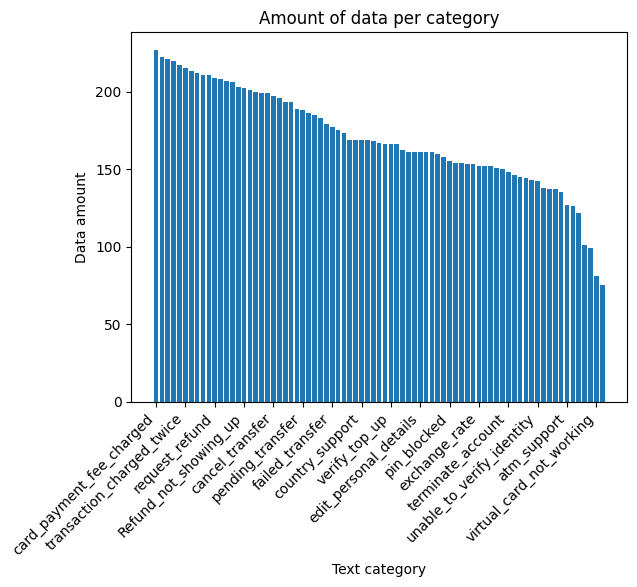

In [98]:

plt.bar(data['category'].value_counts().index ,data['category'].value_counts());
plt.xticks(data['category'].value_counts().index[::5]);
plt.xticks(rotation=45, ha='right');
plt.xlabel('Text category');
plt.ylabel('Data amount');
plt.title('Amount of data per category');


Text(0.5, 1.0, 'char count')

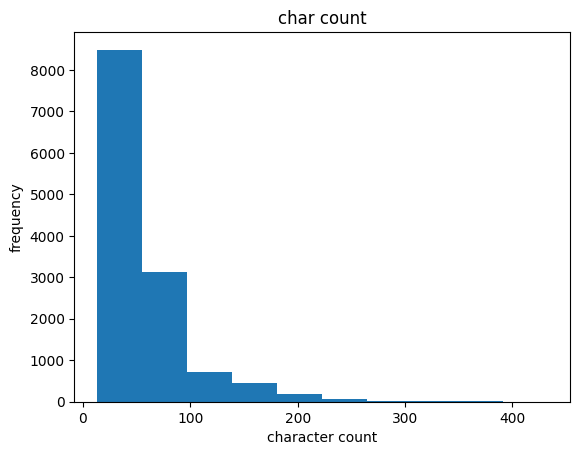

In [87]:
plt.hist(data['char_count']);
plt.xlabel('character count');
plt.ylabel('frequency');
plt.title('char count')

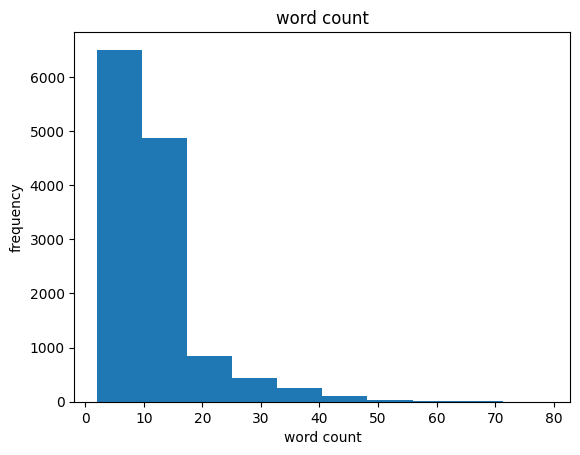

In [90]:
plt.hist(data['word_count']);
plt.xlabel('word count');
plt.ylabel('frequency');
plt.title('word count');

/Users/mariusnwobi/opt/anaconda3/envs/PNC/lib/python3.13/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, ' Top 20 frequent words ')

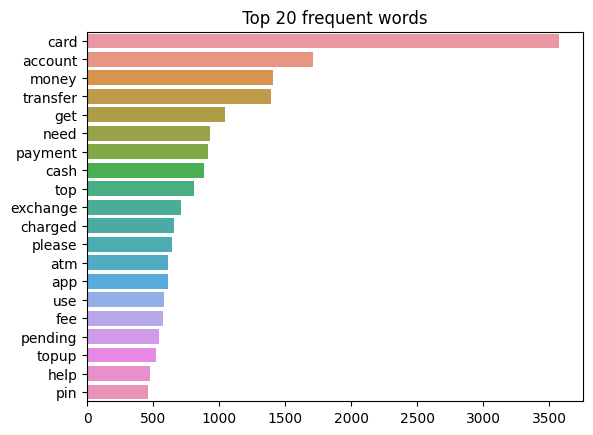

In [107]:
from collections import Counter

word_freq = Counter(" ".join(data['text'].apply(remove_stopwords)).split()).most_common(20)
sns.barplot(x=[val[1] for val in word_freq], y=[val[0] for val in word_freq])
plt.title('Top 20 frequent words ')

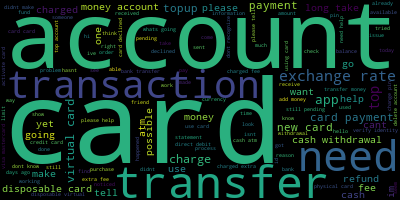

In [125]:
from wordcloud import WordCloud
WordCloud().generate(" ".join(data['text'].apply(remove_stopwords))).to_image()

# Attempting to seperate text as non anamoly vs anamoly ( no exact convetion yet)
After go back and look at labeling or orgainzing categories since this could affect modeling

In [127]:
non_anom=['card_linking','activate_my_card','visa_or_mastercard','card_linking',
          'visa_or_mastercard','country_support','supported_cards_and_currencies'
          ,'fiat_currency_support','card_acceptance','edit_personal_details'
          ,'getting_spare_card','card_about_to_expire','apple_pay_or_google_pay',
          'order_physical_card','exchange_rate','card_delivery_estimate','age_limit']
len(non_anom)

data['class']=data['category'].apply(lambda x: 0 if x in non_anom else 1 )

Usually anomalies are supposed to be less but in this case it's not 

In our case, the actual anamolies are the "regular fluctations" and non anamolies are the "fluctations"

Text(0.5, 0, 'Class #')

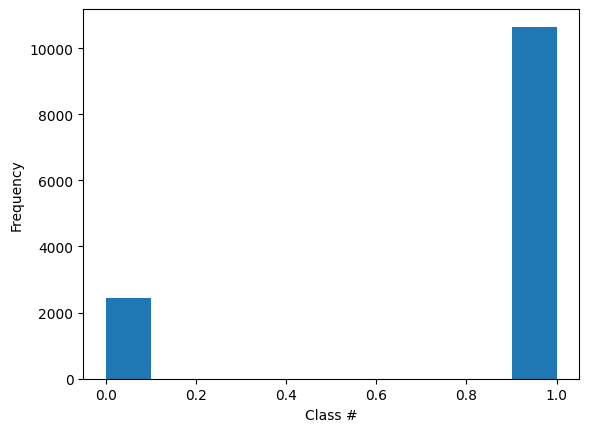

In [128]:
# 0 is non anomily and 1 is anomaly 
data['class'].plot(kind='hist')
plt.xlabel('Class #')

# Plan of approach 
1.  Can start off by making the model shown in the polyai journal to create labels for you text with no labels(new new data)

2. Then try out the differnt models ranging from deep to reg Text claasisifcation models from journal. ( try out semi labled)

3. if can't make model from polyai then work on sentemin analysis and try to do fraud dectection from there based on sentiment. 

4. can also try ensemble method with mult models, mult models with sentiment and text, or mult models based on text for example. 






# Attempting TFIDF and OneClassSVM as baseline

TFIDF will remove stop words and train test split with 80/20 

In [130]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    strip_accents='unicode',
    lowercase=True
)

vec_data=vectorizer.fit_transform(data['text'])

# train test split 
train_x,test_x,train_y,test_y= train_test_split(vec_data,data['class'],train_size=.8)

In [131]:
# creating model 
model = OneClassSVM(
    kernel='linear',     # Radial basis function kernel
    gamma=0.1,        # Kernel coefficient
    nu=0.1           # Upper bound on fraction of outliers
)

# Train the model
model.fit(train_x.toarray())

# Make predictions
y_pred = model.predict(test_x.toarray())

# in this case since non anomaly is the minority ( the model thinks non anomalies is the anomalies ) or in this case the anamoly are the " non anamanious comments"

####### Orig predictions #########
y_pred = np.where(y_pred == -1, 0, 1)  

########### use anomaly scores to get predictions  ###########
anomaly_scores = model.score_samples(test_x.toarray()) # lower scores more anominous higher scores less
threshold = np.percentile(anomaly_scores, 95)  # 5th percentile as threshold ( captures the lowest scores can lower percitle to capture the most bottomist)
predictions = np.where(anomaly_scores > threshold, 0, 1)  # 1 for normal, -1 for anomalies


# or can use anomaly score directly and find x percent for cutoff  
# Convert scores to probabilities (0 to 1 scale)
normalized_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))
predictions_norm = np.where(normalized_scores > .5, 0, 1) 

Accuracy from model it's self

In [132]:
print(accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.7359572029040886
              precision    recall  f1-score   support

           0       0.22      0.16      0.18       496
           1       0.82      0.87      0.84      2121

    accuracy                           0.74      2617
   macro avg       0.52      0.51      0.51      2617
weighted avg       0.70      0.74      0.72      2617



Based on anaomly scores

In [133]:
# Based on 95 percentile
print(accuracy_score(test_y,predictions))
print(classification_report(test_y,predictions))

0.7657623232709209
              precision    recall  f1-score   support

           0       0.05      0.01      0.02       496
           1       0.80      0.94      0.87      2121

    accuracy                           0.77      2617
   macro avg       0.43      0.48      0.44      2617
weighted avg       0.66      0.77      0.71      2617



Based on normalization

In [134]:
# Based on  normlization
print(accuracy_score(test_y,predictions_norm))
print(classification_report(test_y,predictions_norm))

0.6224684753534582
              precision    recall  f1-score   support

           0       0.10      0.13      0.11       496
           1       0.78      0.74      0.76      2121

    accuracy                           0.62      2617
   macro avg       0.44      0.43      0.44      2617
weighted avg       0.65      0.62      0.64      2617



# Visualizing 

This can show how my threshold influences the anamoly cutoff

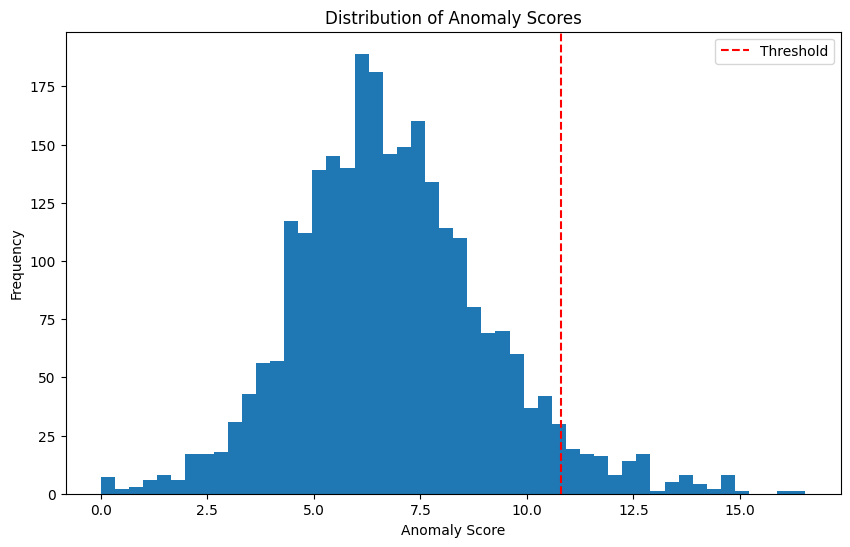

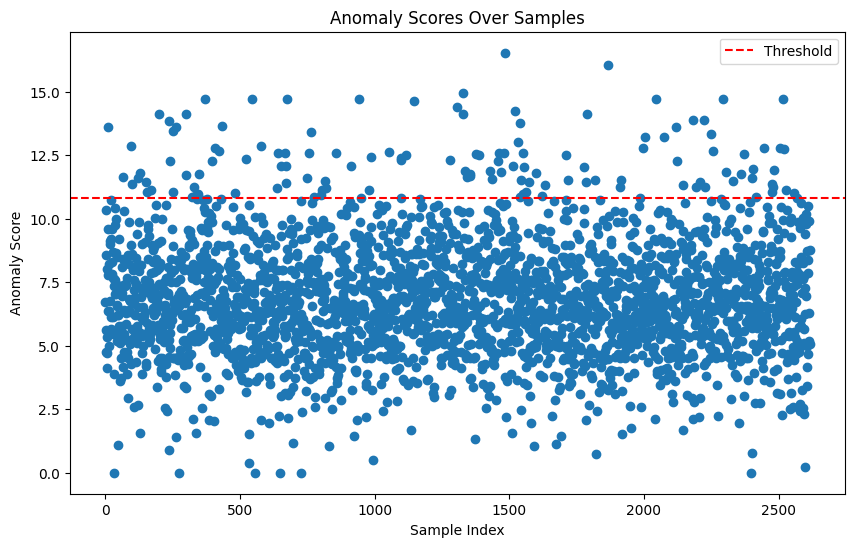

In [135]:
import matplotlib.pyplot as plt

# Plot score distribution
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot scores over time
plt.figure(figsize=(10, 6))
plt.scatter(range(0,len(anomaly_scores)),anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()


ROC curve


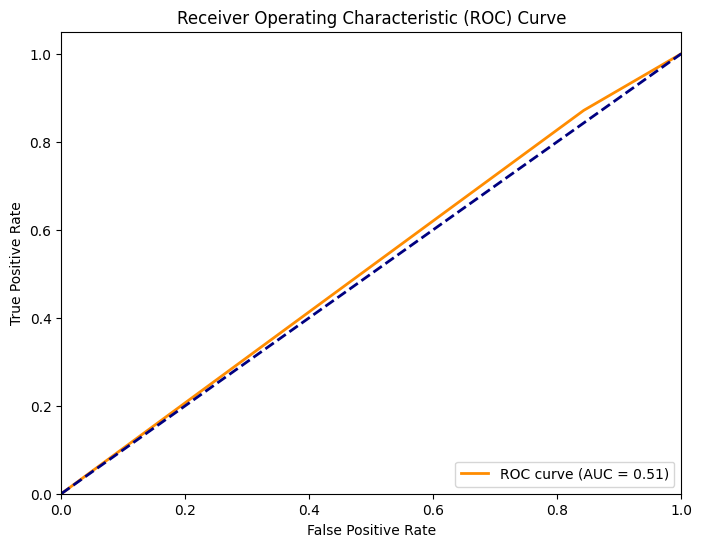

In [136]:
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


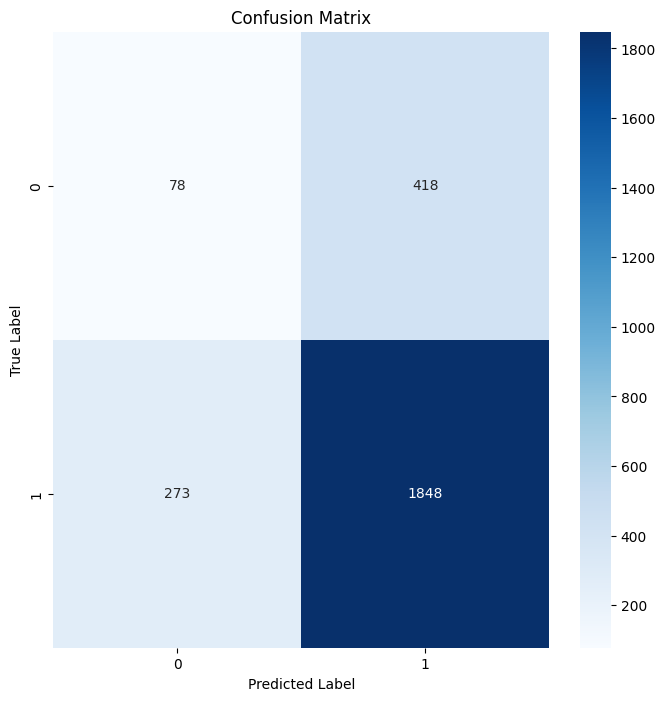

In [137]:
cm = confusion_matrix(test_y, y_pred)

# Create visualization
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Overall model isn't good due to lack of ability to detect or label anamolies 

# another way to get threshold

In [80]:
# Get top N anomalies
top_n = 10
top_anomaly_indices = np.argsort(anomaly_scores)[:top_n]
top_anomaly_scores = anomaly_scores[top_anomaly_indices]

# Calculate confidence scores (higher score = more likely to be normal)
confidence_scores = 1 - normalized_scores

0.2178910544727636

# Results  
As a result we can see we can currentl see that the model is terrbile. we should go back and revise how we're creating our labels since we have more anomlies than actual normal text which should be the other way around  

change number of steps for R hw 